In [1]:
% matplotlib notebook
import numpy as np
from model import HSRobustNet
from utils import *

In [2]:
class Trainer():
    def __init__(self, model, dset):
        self.dset = dset
        self.model = model
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def train(self, epochs=1, test_every=100, train_fun=None, verbose=False):
        if train_fun is None:
            train_fun = self.model.train
        N = len(self.dset.y_train)
        acc = []
        grad = []
        for epoch in range(epochs):
            avg_loss = 0
            for i in range(N):
                y_train_oh = self.one_hot_encoding(self.dset.y_train)

                _, loss = self.sess.run([train_fun, self.model.loss],
                                        {self.model.X: self.dset.x_train, self.model.Y: y_train_oh})
                avg_loss += loss / float(N)


            if epoch % test_every == 0:
                chi2dist, grad_norm = self.sess.run([self.model.chi2, self.model.grad_norm], 
                                                    {self.model.X: self.dset.x_train, self.model.Y: y_train_oh})
                grad.append(np.sum(grad_norm))

                pred, loss, acc_ = self.test()
                acc.append(acc_)
                
                if verbose:
                    print("Epoch: {}, chi2dist: {}, Grad_norm: {}, Accuracy: {}".format(epoch, chi2dist, grad_norm, acc_))

        return np.array(acc), np.array(grad)

    def test(self, verbose=False):
        y_test_oh = self.one_hot_encoding(self.dset.y_test)
        pred, loss = self.sess.run([self.model.pred, self.model.test_loss],
                                   {self.model.X_test: self.dset.x_test, self.model.Y: y_test_oh})
        pred = np.reshape(np.around(pred, 0), -1)
        acc = np.mean(np.equal(pred, self.dset.y_test))
        if verbose:
            print("Accuracy: {}, Test loss: {}".format(acc, loss))

        return pred, loss, acc

    def perturb(self, _var="theta"):
        if _var == 'theta':
            self.sess.run(self.model.perturb_theta)
        elif _var == 'phi':
            self.sess.run(self.model.perturb_phi)


    def one_hot_encoding(self, y):
        n = len(np.unique(self.dset.y_train))
        y_oh = np.zeros((len(y), n))
        y_oh[np.arange(len(y)), y] = 1
        return y_oh

    def decode_oh(self, y_oh):
        return np.argmax(y_oh, axis=1)

# Experiment 1

Epoch: 0, chi2dist: 0.07327775657176971, Grad_norm: (6.5059195, 37.762341), Accuracy: 0.32
Epoch: 100, chi2dist: 0.8707849979400635, Grad_norm: (0.022381889, 0.0014877815), Accuracy: 1.0
Epoch: 0, chi2dist: 0.0043839504942297935, Grad_norm: (5.0533524, 39.632885), Accuracy: 0.8
Epoch: 100, chi2dist: 0.0030069942586123943, Grad_norm: (2.2789531e-05, 3.4958794e-09), Accuracy: 1.0


<IPython.core.display.Javascript object>


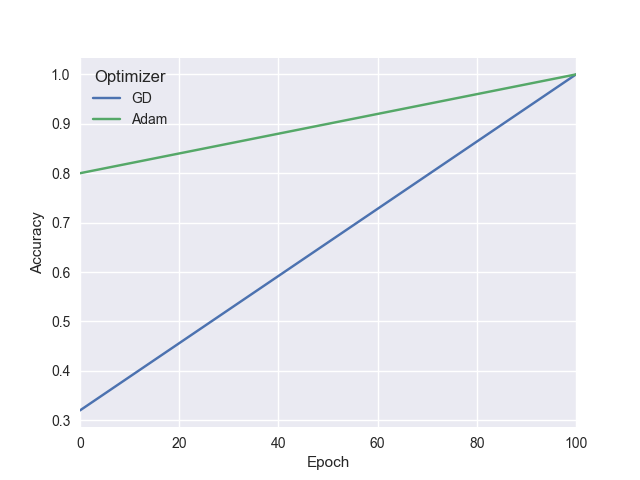

/Users/leonardadolphs/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


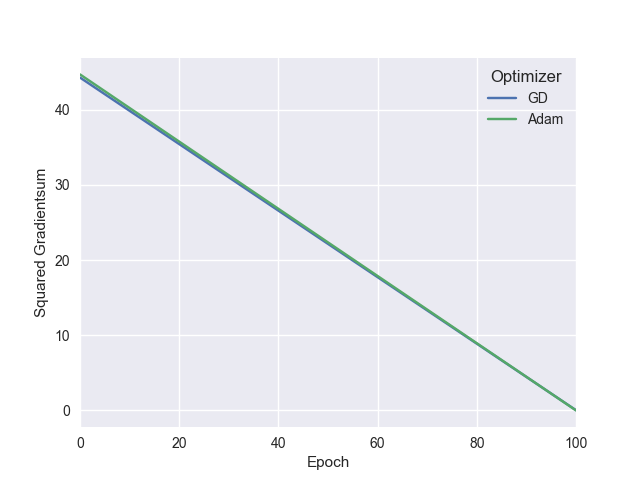

In [3]:
def build_graphs(dset, models_str):
    models = {}
    for key in models_str.split(" "):
        models[key] = HSRobustNet(batch_size=dset.N_train, input_size=dset.dim, out_size=dset.classes,
                                           optim=key)
    return models

def train(epochs, reps):
    dset = DataSet(np.random.randint(100))
    visualizer = Visualizer()
    acc = {}
    grad = {}
    models = {}

    models = build_graphs(dset, "SimultNewton Newton SPNewton")
#     models = build_graphs(dset, "GD Adam")

    seeds = np.random.choice(100, reps, replace=False)

    for i,rep in enumerate(range(reps)):
        dset.reshuffle_split()
        for key in models.keys():
            set_seed(seeds[i])
            acc_, grad_ = Trainer(models[key], dset).train(epochs, test_every=100)
            acc, grad = safe_append(acc, key, acc_), safe_append(grad, key, grad_)

    visualizer.acc_conf_plot(acc, x_every=100, value="Accuracy")
    visualizer.acc_conf_plot(grad, x_every=100, value="Squared Gradientsum")
    
train(2000, 10)

# Experiment 2 (Perturbation)

In this experiment we want to analyze the behaviour of the different optimizer around critical points. We first run Newton's method for 1500 epochs. We can be almost sure that after this many epochs it found a critical point. After 1500 epochs we perturb the model parameters "theta". After the perturbation we go on optimizing the model with the SPNewton optimizer for 2500 epochs to see if it is able to find a better parameterization.

To see that after the perturbation the vanilla Newton optimizer quickly converges back to the initial critical point we construct a new model with exactly the same initial random seed and let it run for the whole 1500 + 2500 epochs, including the perturbation after 1500.

In [ ]:
def flip_training(optim="SimultNewton SPNewton", epochs=[1500, 2500]):
    seed = set_seed(13)
    dset = DataSet(seed)
    visualizer = Visualizer()
    acc = {}
    grad = {}

    model = HSRobustNet(batch_size=dset.N_train, input_size=dset.dim, out_size=dset.classes,
                                       optim=optim)
    trainer = Trainer(model, dset)
    for i, opt in enumerate(optim.split(" ")):
        train_fun = getattr(trainer.model, "train_{}".format(i + 1))
        acc[opt], grad[opt] = trainer.train(epochs=epochs[i], test_every=100, train_fun=train_fun)
        trainer.perturb("theta")

    model.reset()
    seed = set_seed(seed)
    dset = DataSet(seed)
    optim = "{} {}".format(optim.split(" ")[0], optim.split(" ")[0])
    model = HSRobustNet(batch_size=dset.N_train, input_size=dset.dim, out_size=dset.classes, optim=optim)
    trainer = Trainer(model, dset)
    for i, opt in enumerate(optim.split(" ")):
        opt = opt + "_"
        train_fun = getattr(trainer.model, "train_{}".format(i + 1))
        acc[opt], grad[opt] = trainer.train(epochs=epochs[i], test_every=100, train_fun=train_fun)
        trainer.perturb("theta")

    visualizer.vanilla_plot(acc, x_every=100, value="Accuracy", flip=True)
    visualizer.vanilla_plot(grad, x_every=100, value="Logarithm of Squared Gradientsum", flip=True, log=True)
    
flip_training(optim="SimultNewton SPNewton", epochs=[101, 101])
# flip_training()

Epoch: 0, chi2dist: 0.1720324009656906, Grad_norm: (2.6929617, 3.53462), Accuracy: 0.8
Epoch: 100, chi2dist: 0.48788005113601685, Grad_norm: (6.3701023e-08, 2.874172e-10), Accuracy: 0.76
Epoch: 0, chi2dist: 0.4721373915672302, Grad_norm: (0.36219183, 0.51469994), Accuracy: 0.8
